In [1]:
%matplotlib inline

import h2o
import os

import numpy as np
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

import ebaysdk
from ebaysdk.finding import Connection as Finding
from ebaysdk.trading import Connection as Trading
from ebaysdk.exception import ConnectionError

import pickle
from collections import Counter

In [2]:
h2o.init(max_mem_size = "2G")
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_161"; Java(TM) SE Runtime Environment (build 1.8.0_161-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.161-b12, mixed mode)
  Starting server from /Users/donalddressen/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/_2/g4zkl52x7jj31f12j9db9sb00000gn/T/tmp207q7kcu
  JVM stdout: /var/folders/_2/g4zkl52x7jj31f12j9db9sb00000gn/T/tmp207q7kcu/h2o_donalddressen_started_from_python.out
  JVM stderr: /var/folders/_2/g4zkl52x7jj31f12j9db9sb00000gn/T/tmp207q7kcu/h2o_donalddressen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.16.0.4
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_donalddressen_lbd828
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [3]:
with open('/Users/donalddressen/Desktop/auction_data/auctions_df_final.pkl', 'rb') as f:
    auc_df_final = pickle.load(f)

In [4]:
auc_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 34 columns):
auction start time           4000 non-null object
autopays                     4000 non-null object
best offer                   4000 non-null object
bid count                    4000 non-null int64
category ID                  4000 non-null object
category name                4000 non-null object
condition ID                 4000 non-null object
end price                    4000 non-null float64
item ID                      4000 non-null object
item url                     4000 non-null object
missing pic                  4000 non-null int64
number of payment methods    4000 non-null int64
pic url                      4000 non-null object
postal code                  4000 non-null int64
seller percent               4000 non-null float64
seller score                 4000 non-null int64
seller star                  4000 non-null object
selling state                4000 non-null obj

In [5]:
reduce_df = auc_df_final[auc_df_final['bid count'] > 0]

In [6]:
reduce_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2999 entries, 1 to 3999
Data columns (total 34 columns):
auction start time           2999 non-null object
autopays                     2999 non-null object
best offer                   2999 non-null object
bid count                    2999 non-null int64
category ID                  2999 non-null object
category name                2999 non-null object
condition ID                 2999 non-null object
end price                    2999 non-null float64
item ID                      2999 non-null object
item url                     2999 non-null object
missing pic                  2999 non-null int64
number of payment methods    2999 non-null int64
pic url                      2999 non-null object
postal code                  2999 non-null int64
seller percent               2999 non-null float64
seller score                 2999 non-null int64
seller star                  2999 non-null object
selling state                2999 non-null obj

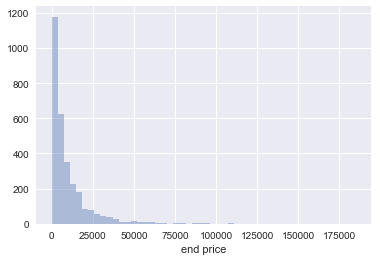

In [7]:
sns.distplot(reduce_df['end price'], kde=False)

In [8]:
reduce_df = reduce_df[reduce_df['missing pic'] < 1]

In [9]:
reduce_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2974 entries, 1 to 3999
Data columns (total 34 columns):
auction start time           2974 non-null object
autopays                     2974 non-null object
best offer                   2974 non-null object
bid count                    2974 non-null int64
category ID                  2974 non-null object
category name                2974 non-null object
condition ID                 2974 non-null object
end price                    2974 non-null float64
item ID                      2974 non-null object
item url                     2974 non-null object
missing pic                  2974 non-null int64
number of payment methods    2974 non-null int64
pic url                      2974 non-null object
postal code                  2974 non-null int64
seller percent               2974 non-null float64
seller score                 2974 non-null int64
seller star                  2974 non-null object
selling state                2974 non-null obj

In [10]:
reduce_df = reduce_df[reduce_df['reserve met'] == 'true']

In [11]:
reduce_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1681 entries, 4 to 3994
Data columns (total 34 columns):
auction start time           1681 non-null object
autopays                     1681 non-null object
best offer                   1681 non-null object
bid count                    1681 non-null int64
category ID                  1681 non-null object
category name                1681 non-null object
condition ID                 1681 non-null object
end price                    1681 non-null float64
item ID                      1681 non-null object
item url                     1681 non-null object
missing pic                  1681 non-null int64
number of payment methods    1681 non-null int64
pic url                      1681 non-null object
postal code                  1681 non-null int64
seller percent               1681 non-null float64
seller score                 1681 non-null int64
seller star                  1681 non-null object
selling state                1681 non-null obj

In [137]:
model_df = pd.concat([ 
    reduce_df['autopays'],
    reduce_df['category ID'],
    reduce_df['condition ID'], 
    reduce_df['end price'], 
    reduce_df['item ID'], 
    reduce_df['number of payment methods'],
    reduce_df['postal code'],
    reduce_df['seller percent'],
    reduce_df['seller score'],
    reduce_df['seller star'],
    reduce_df['title'],
    reduce_df['top rated'],
    reduce_df['description'],
    reduce_df['fuel'],
    reduce_df['make'],
    reduce_df['mileage'],
    reduce_df['photo number'],
    reduce_df['reserve'],
    reduce_df['seller type'],
    reduce_df['start price'],
    reduce_df['vehicle title'],
    reduce_df['year']
], axis=1)

In [138]:
model_df['description'] = model_df['description'].str.len()

In [139]:
model_df['description'] = model_df['description'].fillna(0)

In [140]:
model_df['title'] = model_df['title'].str.len()
model_df['title'] = model_df['title'].fillna(0)

In [141]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1681 entries, 4 to 3994
Data columns (total 22 columns):
autopays                     1681 non-null object
category ID                  1681 non-null object
condition ID                 1681 non-null object
end price                    1681 non-null float64
item ID                      1681 non-null object
number of payment methods    1681 non-null int64
postal code                  1681 non-null int64
seller percent               1681 non-null float64
seller score                 1681 non-null int64
seller star                  1681 non-null object
title                        1681 non-null int64
top rated                    1681 non-null object
description                  1681 non-null float64
fuel                         1681 non-null object
make                         1681 non-null object
mileage                      1681 non-null int64
photo number                 1681 non-null int64
reserve                      1681 non-null obj

In [142]:
Counter(model_df['autopays'])

Counter({'false': 1576, 'true': 105})

In [143]:
Counter(model_df['category ID'])

Counter({'107003': 1,
         '107007': 3,
         '116476': 3,
         '119379': 4,
         '124117': 2,
         '124118': 3,
         '124125': 10,
         '124127': 6,
         '12476': 1,
         '133182': 8,
         '133185': 12,
         '133211': 2,
         '133212': 15,
         '13484': 1,
         '140212': 3,
         '14240': 14,
         '147117': 1,
         '149420': 2,
         '149424': 1,
         '150108': 1,
         '150113': 17,
         '150115': 4,
         '150116': 3,
         '15282': 1,
         '15288': 1,
         '157039': 1,
         '157061': 2,
         '157062': 2,
         '157073': 5,
         '157076': 6,
         '158473': 1,
         '158476': 4,
         '158479': 9,
         '159600': 2,
         '16124': 2,
         '162299': 3,
         '162300': 6,
         '162301': 3,
         '162315': 10,
         '166653': 5,
         '168652': 10,
         '169319': 13,
         '170138': 1,
         '170148': 2,
         '170152': 1,
        

In [144]:
Counter(model_df['condition ID'])

Counter({'1000': 6, '2500': 25, '3000': 1650})

In [145]:
model_df['item ID'] = model_df['item ID'].astype(int)

In [146]:
Counter(model_df['seller star'])

Counter({'Blue': 162,
         'None': 136,
         'Purple': 230,
         'Red': 286,
         'RedShooting': 1,
         'Turquoise': 523,
         'TurquoiseShooting': 4,
         'Yellow': 195,
         'YellowShooting': 144})

In [147]:
Counter(model_df['top rated'])

Counter({'false': 988, 'true': 693})

In [148]:
Counter(model_df['fuel'])

Counter({'Biodiesel': 1,
         'CNG': 7,
         'Diesel': 30,
         'Electric': 12,
         'Ethanol - FFV': 2,
         'Flex Fuel Vehicle': 24,
         'GAS': 1,
         'Gas': 11,
         'Gasoline': 1407,
         'Gasoline Electric Hybrid': 1,
         'Hybrid-Electric': 36,
         'NA': 142,
         'Natural Gas': 1,
         'Regular 87': 1,
         'Regular Gas': 1,
         'Regular unleaded Gasoline': 2,
         'g': 1,
         'premium fuel': 1})

In [149]:
model_df['fuel'] = model_df['fuel'].replace(['NA', 'Gas', 'GAS','Regular 87', 'Regular Gas', 'Regular unleaded Gasoline', 'g', 'premium fuel'], 'Gasoline')
model_df['fuel'] = model_df['fuel'].replace(['Gasoline Electric Hybrid', 'Hybrid-Electric'], 'Hybrid')
model_df['fuel'] = model_df['fuel'].replace('Biodiesel', 'Diesel')
model_df['fuel'] = model_df['fuel'].replace('Ethanol - FFV', 'Flex Fuel Vehicle')
model_df['fuel'] = model_df['fuel'].replace('Biodiesel', 'Diesel')
model_df['fuel'] = model_df['fuel'].replace('Natural Gas', 'CNG')

In [150]:
Counter(model_df['fuel'])

Counter({'CNG': 8,
         'Diesel': 31,
         'Electric': 12,
         'Flex Fuel Vehicle': 26,
         'Gasoline': 1567,
         'Hybrid': 37})

In [151]:
Counter(model_df['make'])

Counter({'AMC': 1,
         'Acura': 32,
         'Alfa Romeo': 3,
         'Audi': 73,
         'BMW': 125,
         'Bentley': 4,
         'Buick': 34,
         'Cadillac': 137,
         'Chevrolet': 119,
         'Chrysler': 38,
         'Datsun': 1,
         'DeSoto': 2,
         'Dodge': 36,
         'Edsel': 1,
         'Fisker': 2,
         'Ford': 130,
         'Honda': 121,
         'Hyundai': 23,
         'Infiniti': 16,
         'Jaguar': 46,
         'Kaiser': 2,
         'Kia': 9,
         'LADA 2106 VAZ 1300 ENGINE 21011': 1,
         'Lexus': 40,
         'Lincoln': 61,
         'Maserati': 12,
         'Mazda': 13,
         'Mercedes-Benz': 167,
         'Mercury': 27,
         'Mini': 3,
         'Mitsubishi': 5,
         'Nissan': 58,
         'Oldsmobile': 12,
         'Other Makes': 2,
         'Plymouth': 5,
         'Pontiac': 23,
         'Renault': 1,
         'Rolls-Royce': 11,
         'Rover': 1,
         'Saab': 13,
         'Saturn': 9,
         'Studebaker

In [152]:
model_df['make'] = model_df['make'].replace('LADA 2106 VAZ 1300 ENGINE 21011', 'Other Makes')

In [153]:
Counter(model_df['make'])

Counter({'AMC': 1,
         'Acura': 32,
         'Alfa Romeo': 3,
         'Audi': 73,
         'BMW': 125,
         'Bentley': 4,
         'Buick': 34,
         'Cadillac': 137,
         'Chevrolet': 119,
         'Chrysler': 38,
         'Datsun': 1,
         'DeSoto': 2,
         'Dodge': 36,
         'Edsel': 1,
         'Fisker': 2,
         'Ford': 130,
         'Honda': 121,
         'Hyundai': 23,
         'Infiniti': 16,
         'Jaguar': 46,
         'Kaiser': 2,
         'Kia': 9,
         'Lexus': 40,
         'Lincoln': 61,
         'Maserati': 12,
         'Mazda': 13,
         'Mercedes-Benz': 167,
         'Mercury': 27,
         'Mini': 3,
         'Mitsubishi': 5,
         'Nissan': 58,
         'Oldsmobile': 12,
         'Other Makes': 3,
         'Plymouth': 5,
         'Pontiac': 23,
         'Renault': 1,
         'Rolls-Royce': 11,
         'Rover': 1,
         'Saab': 13,
         'Saturn': 9,
         'Studebaker': 2,
         'Subaru': 27,
         'Sunbeam'

In [154]:
Counter(model_df['reserve'])

Counter({'false': 1408, 'true': 273})

In [155]:
Counter(model_df['seller type'])

Counter({'AGENT': 1,
         'Auto professional with dealer license': 1,
         'Broker / Dealer': 1,
         'By Owner': 2,
         'DEALER': 1,
         'Dealer': 620,
         'Dealer(SUMMIT AUTO GROUP INC)': 3,
         'Enrique': 1,
         'Midway Auto Sale': 1,
         'Municipality': 1,
         'NA': 153,
         'OWNER': 5,
         'Owner': 16,
         'PRIVATE-COLLECTOR': 1,
         'Private': 1,
         'Private Seller': 854,
         'Private Seller-COLLECTOR': 1,
         'State of Iowa': 1,
         'Transit agency': 1,
         'Wholesale.live': 8,
         'broker': 1,
         'individual': 1,
         'original owner': 1,
         'owner': 3,
         'private owner': 2})

In [156]:
model_df['seller type'] = model_df['seller type'].replace(['AGENT', 'By Owner', 'Enrique','NA', 'OWNER', 'Owner', 'PRIVATE-COLLECTOR', 'Private', 'Private Seller-COLLECTOR', 'individual', 'original owner', 'owner', 'private owner'], 'Private Seller')
model_df['seller type'] = model_df['seller type'].replace(['Auto professional with dealer license', 'Broker / Dealer', 'DEALER','Dealer(SUMMIT AUTO GROUP INC)', 'Midway Auto Sale', 'Wholesale.live', 'broker'], 'Dealer')
model_df['seller type'] = model_df['seller type'].replace(['Municipality', 'State of Iowa', 'Transit agency'], 'Public Seller')

In [157]:
Counter(model_df['seller type'])

Counter({'Dealer': 636, 'Private Seller': 1042, 'Public Seller': 3})

In [158]:
Counter(model_df['vehicle title'])

Counter({'Clear': 1381,
         'Flood, Water Damage': 9,
         'Lemon & Manufacturer Buyback': 4,
         'NA': 1,
         'Rebuilt, Rebuildable & Reconstructed': 201,
         'Salvage': 85})

In [159]:
model_df['vehicle title'] = model_df['vehicle title'].replace('NA', 'Clear')

In [160]:
Counter(model_df['vehicle title'])

Counter({'Clear': 1382,
         'Flood, Water Damage': 9,
         'Lemon & Manufacturer Buyback': 4,
         'Rebuilt, Rebuildable & Reconstructed': 201,
         'Salvage': 85})

In [161]:
# star_mapping = {"None": 0, 
#                 "Yellow": 1, 
#                 "Blue": 2, 
#                 "Turquoise": 3, 
#                 "Purple": 4,
#                 "Red": 5,
#                 "Green": 6,
#                 "YellowShooting": 7,
#                 "TurquoiseShooting": 8,
#                 "PurpleShooting": 9,
#                 "RedShooting": 10,
#                 "GreenShooting": 11,
#                 "SilverShooting": 12
#                }

# model_df['seller star'] = model_df['seller star'].map(star_mapping)
# model_df['seller star'] = model_df['seller star'].fillna(0)

In [162]:
# model_df['top rated'] = model_df['top rated'].astype(bool)

In [163]:
# model_df['top rated'] = model_df['top rated'].astype(int)

In [164]:
# model_df['reserve'] = model_df['reserve'].astype(bool)

In [165]:
# model_df['reserve'] = model_df['reserve'].astype(int)

In [166]:
# model_df['category ID'] = model_df['category ID'].astype(int)

In [167]:
# model_df['condition ID'] = model_df['condition ID'].astype(int)

In [168]:
# model_df['item ID'] = model_df['item ID'].astype(int)

In [169]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1681 entries, 4 to 3994
Data columns (total 22 columns):
autopays                     1681 non-null object
category ID                  1681 non-null object
condition ID                 1681 non-null object
end price                    1681 non-null float64
item ID                      1681 non-null int64
number of payment methods    1681 non-null int64
postal code                  1681 non-null int64
seller percent               1681 non-null float64
seller score                 1681 non-null int64
seller star                  1681 non-null object
title                        1681 non-null int64
top rated                    1681 non-null object
description                  1681 non-null float64
fuel                         1681 non-null object
make                         1681 non-null object
mileage                      1681 non-null int64
photo number                 1681 non-null int64
reserve                      1681 non-null obje

In [69]:
# with open('/Users/donalddressen/Desktop/auction_data/model_df.pkl', 'wb') as f:
#     pickle.dump(model_df, f)

In [171]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [172]:
model_hf = h2o.H2OFrame(model_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [176]:
model_hf.head()

autopays,category ID,condition ID,end price,item ID,number of payment methods,postal code,seller percent,seller score,seller star,title,top rated,description,fuel,make,mileage,photo number,reserve,seller type,start price,vehicle title,year
false,6055,3000,515,2.73033e+11,3,91304,100,343,Turquoise,26,false,295,Gasoline,Audi,180350,13,false,Private Seller,300,Clear,1985
false,16124,3000,1500,2.92413e+11,21,49426,100,19,Yellow,64,false,4135,Gasoline,Buick,74000,13,false,Private Seller,1500,Clear,1993
false,6169,3000,3600,1.12765e+11,2,30043,99.6,3241,Red,63,true,34013,Gasoline,Chevrolet,103085,22,false,Private Seller,200,Clear,2011
false,6169,3000,3355,1.22922e+11,2,30043,99.6,3240,Red,76,true,37041,Gasoline,Chevrolet,115145,24,false,Private Seller,200,Clear,2009
false,171089,3000,6603,3.23014e+11,21,20018,100,263,Turquoise,120,true,159932,Gasoline,Jaguar,128702,24,true,Dealer,999,Clear,2007
false,31851,3000,1075,2.82811e+11,3,6759,100,421,Turquoise,53,false,538,Gasoline,Lincoln,89313,15,false,Private Seller,1000,Clear,2003
false,6170,3000,6900,2.73032e+11,3,48126,100,62,Blue,80,false,772,Gasoline,Chevrolet,45000,5,false,Dealer,4500,"Rebuilt, Rebuildable & Reconstructed",2014
false,6009,3000,910,1.92432e+11,3,10304,75,0,None,32,false,4044,Gasoline,BMW,130000,17,false,Private Seller,0.99,Clear,1992
false,6207,3000,1120,2.02191e+11,3,48044,100,18,Yellow,54,false,633,Gasoline,Dodge,160000,4,false,Private Seller,987,Clear,2004
false,6336,3000,15100,2.82812e+11,3,77001,0,9,None,111,false,11935,Gasoline,Mercedes-Benz,94100,12,false,Private Seller,0.01,Clear,2008


In [182]:
train, valid, test = model_hf.split_frame([0.6, 0.2], seed=1234)

In [183]:
model_X = model_hf.col_names[:3] + model_hf.col_names[4:]

In [187]:
model_Y = model_hf.col_names[3]

In [188]:
model_X

['autopays',
 'category ID',
 'condition ID',
 'item ID',
 'number of payment methods',
 'postal code',
 'seller percent',
 'seller score',
 'seller star',
 'title',
 'top rated',
 'description',
 'fuel',
 'make',
 'mileage',
 'photo number',
 'reserve',
 'seller type',
 'start price',
 'vehicle title',
 'year']

In [189]:
model_Y

'end price'

In [201]:
rf_v1 = H2ORandomForestEstimator(
    model_id="rf_model_v1",
    ntrees=200,
    stopping_rounds=2,
    score_each_iteration=True,
    seed=1000000)

In [202]:
rf_v1.train(model_X, model_Y, training_frame=train, validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [203]:
rf_v1

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_model_v1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 45765203.273207314
RMSE: 6764.998394176256
MAE: 3250.09397361458
RMSLE: 0.7798483501553566
Mean Residual Deviance: 45765203.273207314

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 13845388.237548284
RMSE: 3720.9391606889094
MAE: 2194.1231980020602
RMSLE: 0.657858165155004
Mean Residual Deviance: 13845388.237548284
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-02-03 20:41:40,0.010 sec,0.0,nan,nan,nan,nan,nan,nan
,2018-02-03 20:41:40,0.027 sec,1.0,7930.3161873,4360.2258432,62889914.8311263,5935.6355019,3141.4319565,35231768.8113268
,2018-02-03 20:41:40,0.040 sec,2.0,9325.6201180,4350.3342361,86967190.5851703,4296.3815739,2544.0650375,18458894.6282227
,2018-02-03 20:41:40,0.054 sec,3.0,8427.1228475,3976.7889719,71016399.4861086,4218.8554037,2564.7167155,17798740.9171331
,2018-02-03 20:41:40,0.069 sec,4.0,8299.0507790,3816.2567472,68874243.8330797,3729.8288473,2333.3911881,13911623.2304500
,2018-02-03 20:41:40,0.086 sec,5.0,7583.0184192,3691.3043719,57502168.3453886,3694.3106279,2275.0365053,13647931.0154652
,2018-02-03 20:41:40,0.103 sec,6.0,7180.0017992,3456.5010571,51552425.8360199,3588.7022431,2221.2050756,12878783.7899357
,2018-02-03 20:41:40,0.121 sec,7.0,7028.9487191,3355.3047187,49406120.0953086,3820.3105810,2233.9846989,14594772.9356527
,2018-02-03 20:41:40,0.141 sec,8.0,6764.9983942,3250.0939736,45765203.2732073,3720.9391607,2194.1231980,13845388.2375483


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
make,145181425664.0000000,1.0,0.2668755
year,144411426816.0000000,0.9946963,0.2654601
start price,106416865280.0000000,0.7329923,0.1956177
category ID,17041353728.0000000,0.1173797,0.0313258
condition ID,16076445696.0000000,0.1107335,0.0295521
---,---,---,---
reserve,6109105664.0000000,0.0420791,0.0112299
number of payment methods,5359799808.0000000,0.0369179,0.0098525
vehicle title,3625568256.0000000,0.0249727,0.0066646
seller percent,3515655936.0000000,0.0242156,0.0064626



See the whole table with table.as_data_frame()


In [204]:
gbm_v1 = H2OGradientBoostingEstimator(
    model_id="gbm_model_v1",
    seed=2000000
)

gbm_v1.train(model_X, model_Y, training_frame=train, validation_frame=valid)


gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [206]:
gbm_v1

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_model_v1


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 7665918.710550771
RMSE: 2768.739552675688
MAE: 1496.262267177691
RMSLE: 0.5462895665356556
Mean Residual Deviance: 7665918.710550771

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 12351097.103909587
RMSE: 3514.4127680040074
MAE: 2005.6095336209626
RMSLE: 0.6213677082352018
Mean Residual Deviance: 12351097.103909587
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-02-03 20:44:33,0.017 sec,0.0,9755.7958834,5951.6100596,95175553.3191187,8165.1728548,5483.4555587,66670047.7491488
,2018-02-03 20:44:33,0.055 sec,1.0,9076.3315202,5498.0549099,82379793.8644904,7559.4623362,5058.6133575,57145470.8119894
,2018-02-03 20:44:33,0.068 sec,2.0,8470.6610114,5106.2829391,71752097.9695532,7067.1769513,4734.5469751,49944990.0604065
,2018-02-03 20:44:33,0.082 sec,3.0,7945.8961782,4769.8832166,63137266.0745539,6650.2571830,4468.3982312,44225920.5997473
,2018-02-03 20:44:33,0.098 sec,4.0,7488.1507980,4473.5970635,56072402.3737017,6284.0991622,4231.0396069,39489902.2807623
---,---,---,---,---,---,---,---,---,---
,2018-02-03 20:44:33,0.505 sec,46.0,2872.4146053,1547.3179030,8250765.6648415,3532.4640835,2020.6333944,12478302.5012201
,2018-02-03 20:44:33,0.509 sec,47.0,2814.6763917,1514.9797665,7922403.1900997,3501.5710399,1998.2059868,12260999.7475525
,2018-02-03 20:44:33,0.514 sec,48.0,2793.3660268,1504.1176013,7802893.7596664,3497.6799029,2001.3973096,12233764.7034350
,2018-02-03 20:44:33,0.518 sec,49.0,2782.6603171,1498.0567787,7743198.4403614,3498.6602871,1999.4981188,12240623.8047356



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
make,151172972544.0000000,1.0,0.3240131
year,144702095360.0000000,0.9571955,0.3101439
start price,122090889216.0000000,0.8076238,0.2616807
title,6454943232.0000000,0.0426991,0.0138351
category ID,5244297216.0000000,0.0346907,0.0112402
---,---,---,---
seller type,885464128.0000000,0.0058573,0.0018978
autopays,743119168.0000000,0.0049157,0.0015927
seller percent,531957440.0000000,0.0035189,0.0011402
top rated,271817568.0000000,0.0017981,0.0005826



See the whole table with table.as_data_frame()


In [208]:
gbm_v2 = H2OGradientBoostingEstimator(
    ntrees=20,
    learn_rate=0.2,
    max_depth=10,
    stopping_tolerance=0.01, #10-fold increase in threshold as defined in rf_v1
    stopping_rounds=2,
    score_each_iteration=True,
    model_id="gbm_model_v2",
    seed=2000000
)
gbm_v2.train(model_X, model_Y, training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [209]:
gbm_v2

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_model_v2


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 9684081.230815522
RMSE: 3111.9256467363616
MAE: 1362.353814278515
RMSLE: 0.5052816870783398
Mean Residual Deviance: 9684081.230815522

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 13155422.0906858
RMSE: 3627.0404037845788
MAE: 2139.093237782963
RMSLE: 0.6704274338531896
Mean Residual Deviance: 13155422.0906858
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-02-03 20:52:24,0.015 sec,0.0,9755.7958834,5951.6100596,95175553.3191187,8165.1728548,5483.4555587,66670047.7491488
,2018-02-03 20:52:24,0.028 sec,1.0,8327.5821177,4939.6409351,69348623.9271553,6921.9564696,4626.5885854,47913481.3670731
,2018-02-03 20:52:24,0.037 sec,2.0,7164.1962174,4145.4658041,51325707.4407957,6034.0491203,4013.1107518,36409748.7866789
,2018-02-03 20:52:24,0.045 sec,3.0,6293.7858356,3515.3823432,39611740.1443182,5363.8376197,3516.5768656,28770754.0109456
,2018-02-03 20:52:24,0.054 sec,4.0,5637.4058089,3013.9708305,31780344.2541226,4929.0532715,3177.6770216,24295566.1533356
,2018-02-03 20:52:24,0.062 sec,5.0,5130.8072104,2643.6205644,26325182.6302651,4582.6940399,2877.8752997,21001084.6637746
,2018-02-03 20:52:24,0.071 sec,6.0,4585.2218287,2310.2743412,21024259.2187861,4163.8331512,2645.4692963,17337506.5109579
,2018-02-03 20:52:24,0.081 sec,7.0,4194.2554752,2077.3204638,17591778.9910011,3968.2043591,2498.1481463,15746645.8358415
,2018-02-03 20:52:24,0.090 sec,8.0,3927.3453066,1884.0930725,15424041.1571747,3823.0422211,2373.6309244,14615651.8242485
,2018-02-03 20:52:24,0.100 sec,9.0,3729.8603116,1734.0916099,13911857.9443658,3691.2929621,2273.9077958,13625643.7318569


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
make,78528471040.0000000,1.0,0.3264355
year,74707337216.0000000,0.9513408,0.3105514
start price,62502588416.0000000,0.7959226,0.2598174
mileage,3391727104.0000000,0.0431910,0.0140991
seller star,3331669760.0000000,0.0424263,0.0138494
---,---,---,---
number of payment methods,417017920.0000000,0.0053104,0.0017335
seller percent,134896688.0000000,0.0017178,0.0005608
top rated,24578328.0000000,0.0003130,0.0001022
autopays,0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [241]:
gbm_v3 = H2OGradientBoostingEstimator(
    ntrees=100,
    learn_rate=0.1,
    max_depth=15,
    sample_rate=0.8,
    col_sample_rate=0.8,
    stopping_rounds=4,
    stopping_tolerance=0.01, #10-fold increase in threshold as defined in rf_v1
    score_each_iteration=True,
    model_id="gbm_model_v3",
    seed=2000000
)
gbm_v3.train(model_X, model_Y, training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [280]:
gbm_v3

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_model_v3


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 8140879.391056407
RMSE: 2853.2226325781885
MAE: 1122.086945649549
RMSLE: 0.37607856175430177
Mean Residual Deviance: 8140879.391056407

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 12278211.063504005
RMSE: 3504.0278342935585
MAE: 1982.0664737339077
RMSLE: NaN
Mean Residual Deviance: 12278211.063504005
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-02-03 21:03:12,0.006 sec,0.0,9755.7958834,5951.6100596,95175553.3191187,8165.1728548,5483.4555587,66670047.7491488
,2018-02-03 21:03:12,0.015 sec,1.0,9054.2795923,5476.7053762,81979978.9354831,7648.1627797,5089.5086397,58494393.9053270
,2018-02-03 21:03:12,0.022 sec,2.0,8407.8389343,5020.4926480,70691755.5458895,7191.4770046,4729.1712621,51717341.5080756
,2018-02-03 21:03:12,0.028 sec,3.0,7861.7020244,4621.7071206,61806358.7204405,6778.1181645,4434.5171781,45942885.8518920
,2018-02-03 21:03:12,0.034 sec,4.0,7411.4428306,4261.7878890,54929484.8307457,6393.3548600,4143.6488870,40874986.3653950
---,---,---,---,---,---,---,---,---,---
,2018-02-03 21:03:12,0.223 sec,35.0,3030.1414679,1209.5107972,9181757.3157899,3489.5672718,1990.7645993,12177079.7442352
,2018-02-03 21:03:12,0.228 sec,36.0,3009.0300378,1195.3381240,9054261.7685195,3490.2585454,1990.4315542,12181904.7136742
,2018-02-03 21:03:12,0.233 sec,37.0,2949.1329945,1172.0345930,8697385.4193424,3488.3412809,1988.9180646,12168524.8918245
,2018-02-03 21:03:12,0.238 sec,38.0,2888.6536676,1143.1077556,8344320.0116063,3485.8470497,1980.3273175,12151129.6537170



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
make,124619882496.0000000,1.0,0.2939009
year,118164791296.0000000,0.9482018,0.2786774
start price,117435588608.0000000,0.9423503,0.2769576
category ID,11015391232.0000000,0.0883919,0.0259785
seller star,8414132224.0000000,0.0675184,0.0198437
---,---,---,---
seller type,491317888.0000000,0.0039425,0.0011587
top rated,481141184.0000000,0.0038609,0.0011347
seller percent,403514720.0000000,0.0032380,0.0009516
fuel,273296800.0000000,0.0021930,0.0006445



See the whole table with table.as_data_frame()


In [281]:
gbm_v3._model_json['output']['variable_importances'].as_data_frame()

,variable,relative_importance,scaled_importance,percentage
0,make,1.246199e+11,1.000000,0.293901
1,year,1.181648e+11,0.948202,0.278677
2,start price,1.174356e+11,0.942350,0.276958
3,category ID,1.101539e+10,0.088392,0.025978
4,seller star,8.414132e+09,0.067518,0.019844
5,mileage,7.987872e+09,0.064098,0.018838
6,postal code,7.210625e+09,0.057861,0.017005
7,title,5.025537e+09,0.040327,0.011852
8,reserve,4.754995e+09,0.038156,0.011214
9,vehicle title,3.198605e+09,0.025667,0.007544


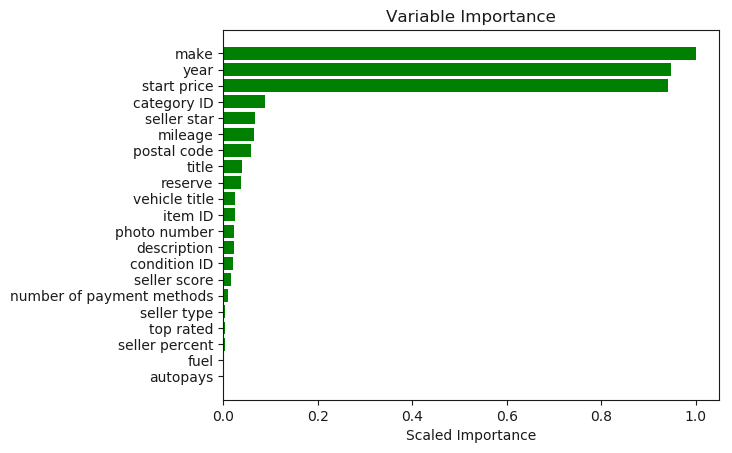

In [282]:
plt.rcdefaults()
fig, ax = plt.subplots()
variables = gbm_v3._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = gbm_v3._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

In [247]:
rf_v2 = H2ORandomForestEstimator(
    model_id="rf_model_v2",
    ntrees=500,
    max_depth=50,
    stopping_rounds=2,
    stopping_tolerance=0.01,
    score_each_iteration=True,
    seed=3000000)
rf_v2.train(model_X, model_Y, training_frame=train, validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [258]:
rf_v2

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_model_v2


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 34247445.42004253
RMSE: 5852.1316987951095
MAE: 2969.2204874137483
RMSLE: 0.7521538535143514
Mean Residual Deviance: 34247445.42004253

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 12709381.53397301
RMSE: 3565.0219542063146
MAE: 2156.6748525120943
RMSLE: 0.6495870521427819
Mean Residual Deviance: 12709381.53397301
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-02-03 21:06:50,0.007 sec,0.0,nan,nan,nan,nan,nan,nan
,2018-02-03 21:06:50,0.026 sec,1.0,6944.9736420,3741.9555392,48232658.8879316,7511.5373960,3804.4991915,56423194.0521859
,2018-02-03 21:06:50,0.042 sec,2.0,7036.7120377,3797.4505244,49515316.3009385,5036.7898730,2907.8150667,25369252.2250873
,2018-02-03 21:06:50,0.054 sec,3.0,6096.3642474,3421.8496454,37165657.0375851,4136.0770887,2557.3750804,17107133.6839111
,2018-02-03 21:06:50,0.066 sec,4.0,5775.5216324,3234.4172871,33356650.1266077,3747.4670117,2318.6387788,14043509.0039958
,2018-02-03 21:06:50,0.079 sec,5.0,5722.3971800,3163.8461130,32745829.4856949,3507.4227713,2184.5336200,12302014.4966396
,2018-02-03 21:06:50,0.097 sec,6.0,5709.3911815,3114.1313333,32597147.6630198,3386.2212982,2098.3885703,11466494.6802910
,2018-02-03 21:06:50,0.113 sec,7.0,6519.0346008,3096.7022056,42497812.1264820,3443.8683031,2116.8827906,11860228.8894346
,2018-02-03 21:06:51,0.141 sec,8.0,6055.1697156,3053.9351604,36665080.2851339,3462.8880697,2116.6981176,11991593.7830722
,2018-02-03 21:06:51,0.161 sec,9.0,5852.1316988,2969.2204874,34247445.4200425,3565.0219542,2156.6748525,12709381.5339730


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
year,135539523584.0000000,1.0,0.2265258
start price,121289867264.0000000,0.8948672,0.2027105
make,99650699264.0000000,0.7352151,0.1665452
fuel,42986770432.0000000,0.3171530,0.0718434
category ID,33037557760.0000000,0.2437485,0.0552153
---,---,---,---
number of payment methods,6649794560.0000000,0.0490617,0.0111137
reserve,6083643392.0000000,0.0448846,0.0101675
seller percent,2947246080.0000000,0.0217446,0.0049257
top rated,2433391360.0000000,0.0179534,0.0040669



See the whole table with table.as_data_frame()


In [256]:
test.describe()

Rows:322
Cols:22




,autopays,category ID,condition ID,end price,item ID,number of payment methods,postal code,seller percent,seller score,seller star,title,top rated,description,fuel,make,mileage,photo number,reserve,seller type,start price,vehicle title,year
type,enum,int,int,real,int,int,int,real,int,enum,int,enum,int,enum,enum,int,int,enum,enum,real,enum,int
mins,,5333.0,2500.0,200.0,112697619681.0,2.0,0.0,0.0,0.0,,22.0,,14.0,,,-1.0,1.0,,,0.01,,1926.0
mean,,37825.239130434784,2993.788819875774,7650.566149068327,242951631727.39438,3.822981366459628,49031.76708074533,93.39844720496895,1907.2236024844722,,83.24534161490685,,38315.049689441,,,414998.3291925465,15.133540372670812,,,2596.235310559008,,2001.568322981367
maxs,,181459.0,3000.0,76500.0,401477026138.0,21.0,98056.0,100.0,39823.0,,158.0,,487248.0,,,99999999.0,24.0,,,74770.0,,2017.0
sigma,,57378.95098923369,55.46679958248757,9604.571182949792,78395790036.31573,2.453879843483799,30467.208411827858,22.394143456107404,4456.48404988931,,30.132398292037358,,64647.340598115385,,,5567700.263350089,7.5914482473461184,,,7372.620579229305,,15.735052927676842
zeros,,0,0,0,0,0,5,17,9,,0,,0,,,3,0,,,0,,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,false,6169.0,3000.0,3355.0,122921504563.0,2.0,30043.0,99.6,3240.0,Red,76.0,true,37041.0,Gasoline,Chevrolet,115145.0,24.0,false,Private Seller,200.0,Clear,2009.0
1,false,6336.0,3000.0,15100.0,282812265430.0,3.0,77001.0,0.0,9.0,None,111.0,false,11935.0,Gasoline,Mercedes-Benz,94100.0,12.0,false,Private Seller,0.01,Clear,2008.0
2,false,6017.0,3000.0,14500.0,332523120225.0,5.0,60656.0,100.0,51.0,Blue,79.0,false,1599.0,Gasoline,Toyota,26800.0,23.0,false,Dealer,200.0,Clear,2017.0


In [259]:
t1_hf = test[:3]
t2_hf = test[4:]

t3_hf = t1_hf.cbind(t2_hf)

In [260]:
final_gbm_predictions = gbm_v3.predict(t3_hf)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [275]:
final_gbm_predictions

predict
2868.04
11339.2
17920.9
24969.4
5714.4
15256.1
9571.54
4422.36
2150.32
3460.03


In [276]:
test

autopays,category ID,condition ID,end price,item ID,number of payment methods,postal code,seller percent,seller score,seller star,title,top rated,description,fuel,make,mileage,photo number,reserve,seller type,start price,vehicle title,year
false,6169,3000,3355,1.22922e+11,2,30043,99.6,3240,Red,76,true,37041,Gasoline,Chevrolet,115145,24,false,Private Seller,200,Clear,2009
false,6336,3000,15100,2.82812e+11,3,77001,0,9,None,111,false,11935,Gasoline,Mercedes-Benz,94100,12,false,Private Seller,0.01,Clear,2008
false,6017,3000,14500,3.32523e+11,5,60656,100,51,Blue,79,false,1599,Gasoline,Toyota,26800,23,false,Dealer,200,Clear,2017
false,43903,3000,16477,2.63441e+11,4,48125,100,1096,Red,64,true,8164,Gasoline,Cadillac,14894,23,false,Dealer,200,"Rebuilt, Rebuildable & Reconstructed",2015
false,6003,3000,4550,2.73031e+11,2,8610,97.7,834,Purple,97,true,66432,Gasoline,Audi,122437,24,false,Dealer,1000,Clear,2008
false,6254,3000,16300,1.32473e+11,5,48126,100,341,Turquoise,88,true,60515,Gasoline,Honda,700,23,false,Dealer,200,"Rebuilt, Rebuildable & Reconstructed",2017
false,133212,3000,7856,1.22922e+11,4,92346,100,106,Turquoise,146,true,14810,Gasoline,Ford,105316,12,false,Dealer,200,Clear,2015
false,6227,3000,3600,3.91963e+11,3,21227,99.5,774,Purple,116,true,13015,Gasoline,Ford,98940,1,false,Private Seller,100,Clear,2011
false,179884,3000,200,3.91966e+11,3,92805,98.4,14288,YellowShooting,103,true,98356,Gasoline,Infiniti,252041,12,false,Private Seller,200,Salvage,2003
false,6146,3000,9500,1.32473e+11,2,98056,100,18,Yellow,100,false,686,Gasoline,Cadillac,140000,12,true,Private Seller,0.99,Clear,1966


In [272]:
test_mean = test['end price'].as_data_frame(use_pandas=True).mean()

In [277]:
(abs(final_gbm_predictions['predict'] - test['end price'])).as_data_frame(use_pandas=True).mean()

abs(predict)    2374.27493
dtype: float64

In [278]:
2374/test_mean*100

end price    31.030383
dtype: float64

In [284]:
h2o.cluster().shutdown(prompt=False)